In [4]:
import matplotlib.pyplot as plt
import numpy as np
import keras


from sklearn.model_selection import cross_validate

from evaluator import Plotter, Evaluator
from dataset_preprocessor import Preprocessor, MinMax_Scaler, Standard_Scaler
from database import Database

In [5]:
IEMOCAP_db_train = Database('IEMOCAP')
IEMOCAP_db_train.print_balance()
IEMOCAP_db_val = Database('IEMOCAP_validation')
IEMOCAP_db_val.print_balance()
IEMOCAP_db_test = Database('IEMOCAP_test')
IEMOCAP_db_test.print_balance()

Meld_db_train = Database('Meld')
Meld_db_train.print_balance()
Meld_db_val = Database('Meld_validation')
Meld_db_val.print_balance()
Meld_db_test = Database('Meld_test')
Meld_db_test.print_balance()

positives_no_aug: 1103
negatives_no_aug: 6429
postives_aug: 4412
negatives_aug: 25716
Total_positives: 5515
Total_negatives: 32145
positives_no_aug: 138
negatives_no_aug: 991
postives_aug: 0
negatives_aug: 0
Total_positives: 138
Total_negatives: 991
positives_no_aug: 154
negatives_no_aug: 975
postives_aug: 0
negatives_aug: 0
Total_positives: 154
Total_negatives: 975
positives_no_aug: 1074
negatives_no_aug: 8608
postives_aug: 4296
negatives_aug: 34428
Total_positives: 5370
Total_negatives: 43036
positives_no_aug: 142
negatives_no_aug: 1310
postives_aug: 0
negatives_aug: 0
Total_positives: 142
Total_negatives: 1310
positives_no_aug: 166
negatives_no_aug: 1286
postives_aug: 0
negatives_aug: 0
Total_positives: 166
Total_negatives: 1286


In [6]:
(
    _,
    _,
    Meld_x_train,
    Meld_y_train,
    _,
    _,
) = Meld_db_train.get_datasets()

(
    Meld_x_test,
    Meld_y_test,
    _,
    _,
    _,
    _,
) = Meld_db_test.get_datasets()

(
    Meld_x_val,
    Meld_y_val,
    _,
    _,
    _,
    _,
) = Meld_db_val.get_datasets()

(
    _,
    _,
    IEMOCAP_x_train,
    IEMOCAP_y_train,
    _,
    _,
) = IEMOCAP_db_train.get_datasets()

(
    IEMOCAP_x_test,
    IEMOCAP_y_test,
    _,
    _,
    _,
    _,
) = IEMOCAP_db_test.get_datasets()

(
    IEMOCAP_x_val,
    IEMOCAP_y_val,
    _,
    _,
    _,
    _,
) = IEMOCAP_db_val.get_datasets()

In [17]:
import re
import pandas as pd

In [24]:
x_train = IEMOCAP_x_train
y_train = IEMOCAP_y_train
x_test = IEMOCAP_x_test
y_test = IEMOCAP_y_test


In [39]:

x_train = np.concatenate((Meld_x_train, IEMOCAP_x_train))
y_train = np.concatenate((Meld_y_train, IEMOCAP_y_train))

x_test = np.concatenate((Meld_x_test, IEMOCAP_x_test))
y_test = np.concatenate((Meld_y_test, IEMOCAP_y_test))

x_val = np.concatenate((Meld_x_val, IEMOCAP_x_val))
y_val = np.concatenate((Meld_y_val, IEMOCAP_y_val))

In [103]:
x_train = x_train[:,:16]
x_test = x_test[:, :16]

In [40]:
scaler = Standard_Scaler()
preprocessor = Preprocessor(scaler, 1)
# x_train, y_train = preprocessor.downsample(x_train, y_train, 0, 0.8)
x_train = preprocessor.scale(x_train, y_train)
x_train, y_train = preprocessor.shuffle(x_train, y_train)

print(len(y_train))
print(sum(y_train))
w = len(y_train) / sum(y_train)
print(w)

86066
10885
7.906844281120809


In [41]:
scaler = Standard_Scaler()
preprocessor = Preprocessor(scaler, 1)
# x_test, y_test = preprocessor.downsample(x_test, y_test, 0, 0.85)
x_test = preprocessor.scale(x_test, y_test)
x_test, y_test = preprocessor.shuffle(x_test, y_test)
print(len(y_test))
print(sum(y_test))

2581
320


In [81]:
scaler = MinMax_Scaler()
preprocessor = Preprocessor(scaler, 1)
x_val, y_val = preprocessor.downsample(x_val, y_val, 0, 0.85)
x_val = preprocessor.scale(x_val, y_val)
x_val, y_val = preprocessor.shuffle(x_val, y_val)
print(len(y_val))
print(sum(y_val))

287
138


## MLP Classifier - Manual

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.models import Model, load_model, Sequential
from numpy.random import seed
tf.random.set_seed(3)



In [42]:
mlp = Sequential()
mlp.add(Input(shape=(57, )))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(8, activation='relu'))
mlp.add(Dense(4, activation='relu'))
mlp.add(Dense(2, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.summary()
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)
,tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               7424      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_33 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_36 (Dense)             (None, 2)                

In [43]:
history = mlp.fit(x=x_train, y=y_train, epochs=50, validation_data=(x_test, y_test), verbose=1, class_weight={1:w, 0:1}).history

Epoch 1/50
2690/2690 [==============================] - 14s 5ms/step - loss: 1.2856 - binary_accuracy: 0.4566 - recall_5: 0.7142 - val_loss: 0.6843 - val_binary_accuracy: 0.4719 - val_recall_5: 0.8469
Epoch 2/50
2690/2690 [==============================] - 17s 6ms/step - loss: 1.2280 - binary_accuracy: 0.5251 - recall_5: 0.7138 - val_loss: 0.7725 - val_binary_accuracy: 0.4018 - val_recall_5: 0.9156
Epoch 3/50
2690/2690 [==============================] - 18s 7ms/step - loss: 1.2250 - binary_accuracy: 0.5215 - recall_5: 0.7300 - val_loss: 0.7774 - val_binary_accuracy: 0.4002 - val_recall_5: 0.9094
Epoch 4/50
2690/2690 [==============================] - 16s 6ms/step - loss: 1.2157 - binary_accuracy: 0.5340 - recall_5: 0.7211 - val_loss: 0.7327 - val_binary_accuracy: 0.4622 - val_recall_5: 0.8875
Epoch 5/50
2690/2690 [==============================] - 15s 6ms/step - loss: 1.2177 - binary_accuracy: 0.5234 - recall_5: 0.7406 - val_loss: 0.7551 - val_binary_accuracy: 0.4599 - val_recall_5: 0.

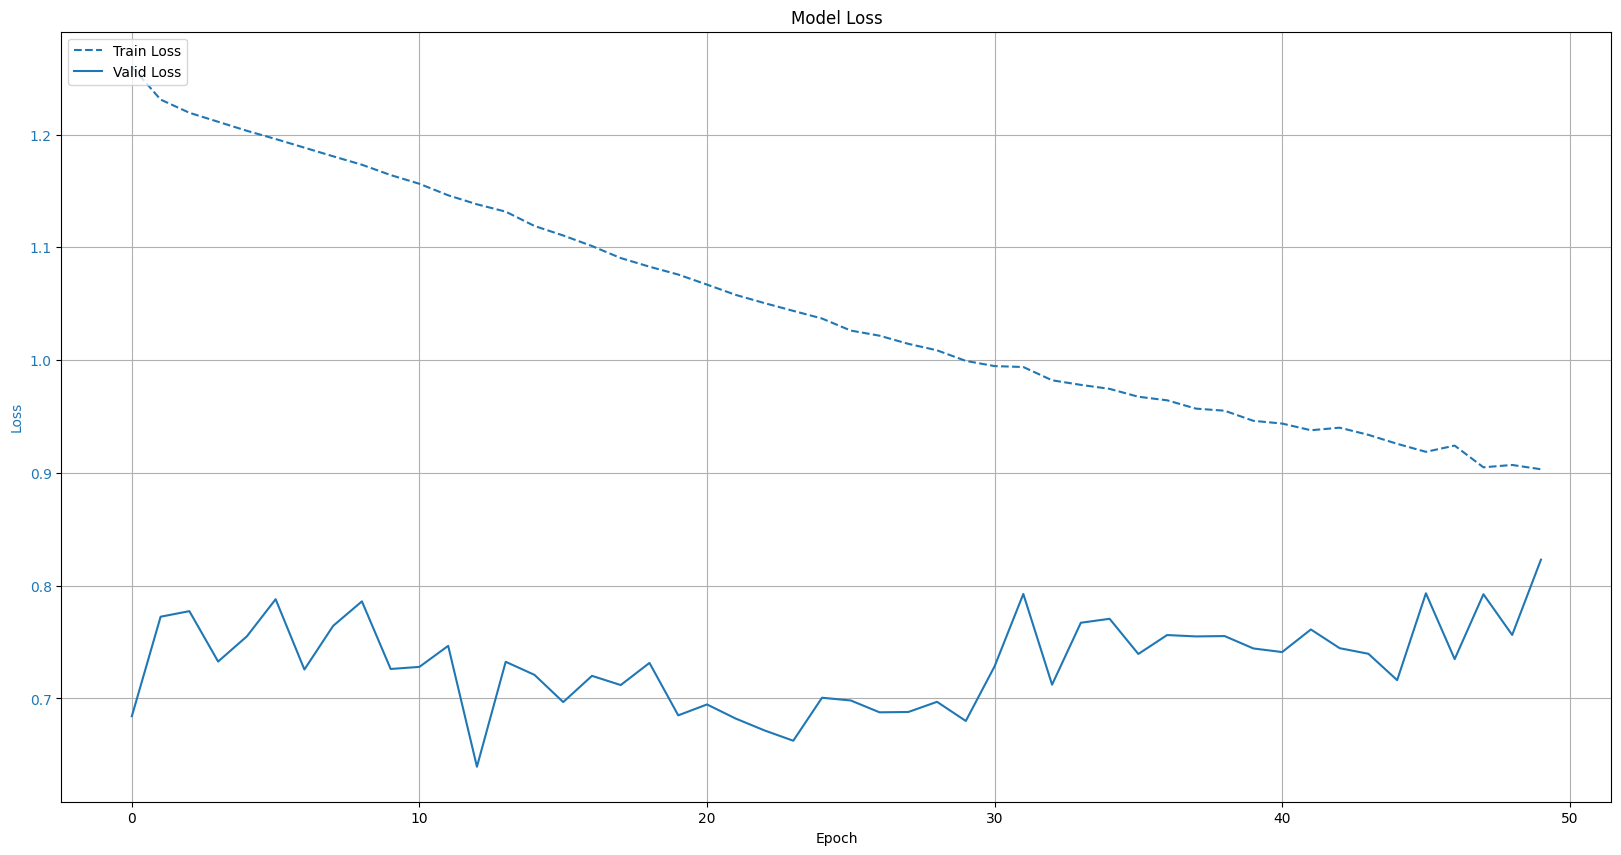

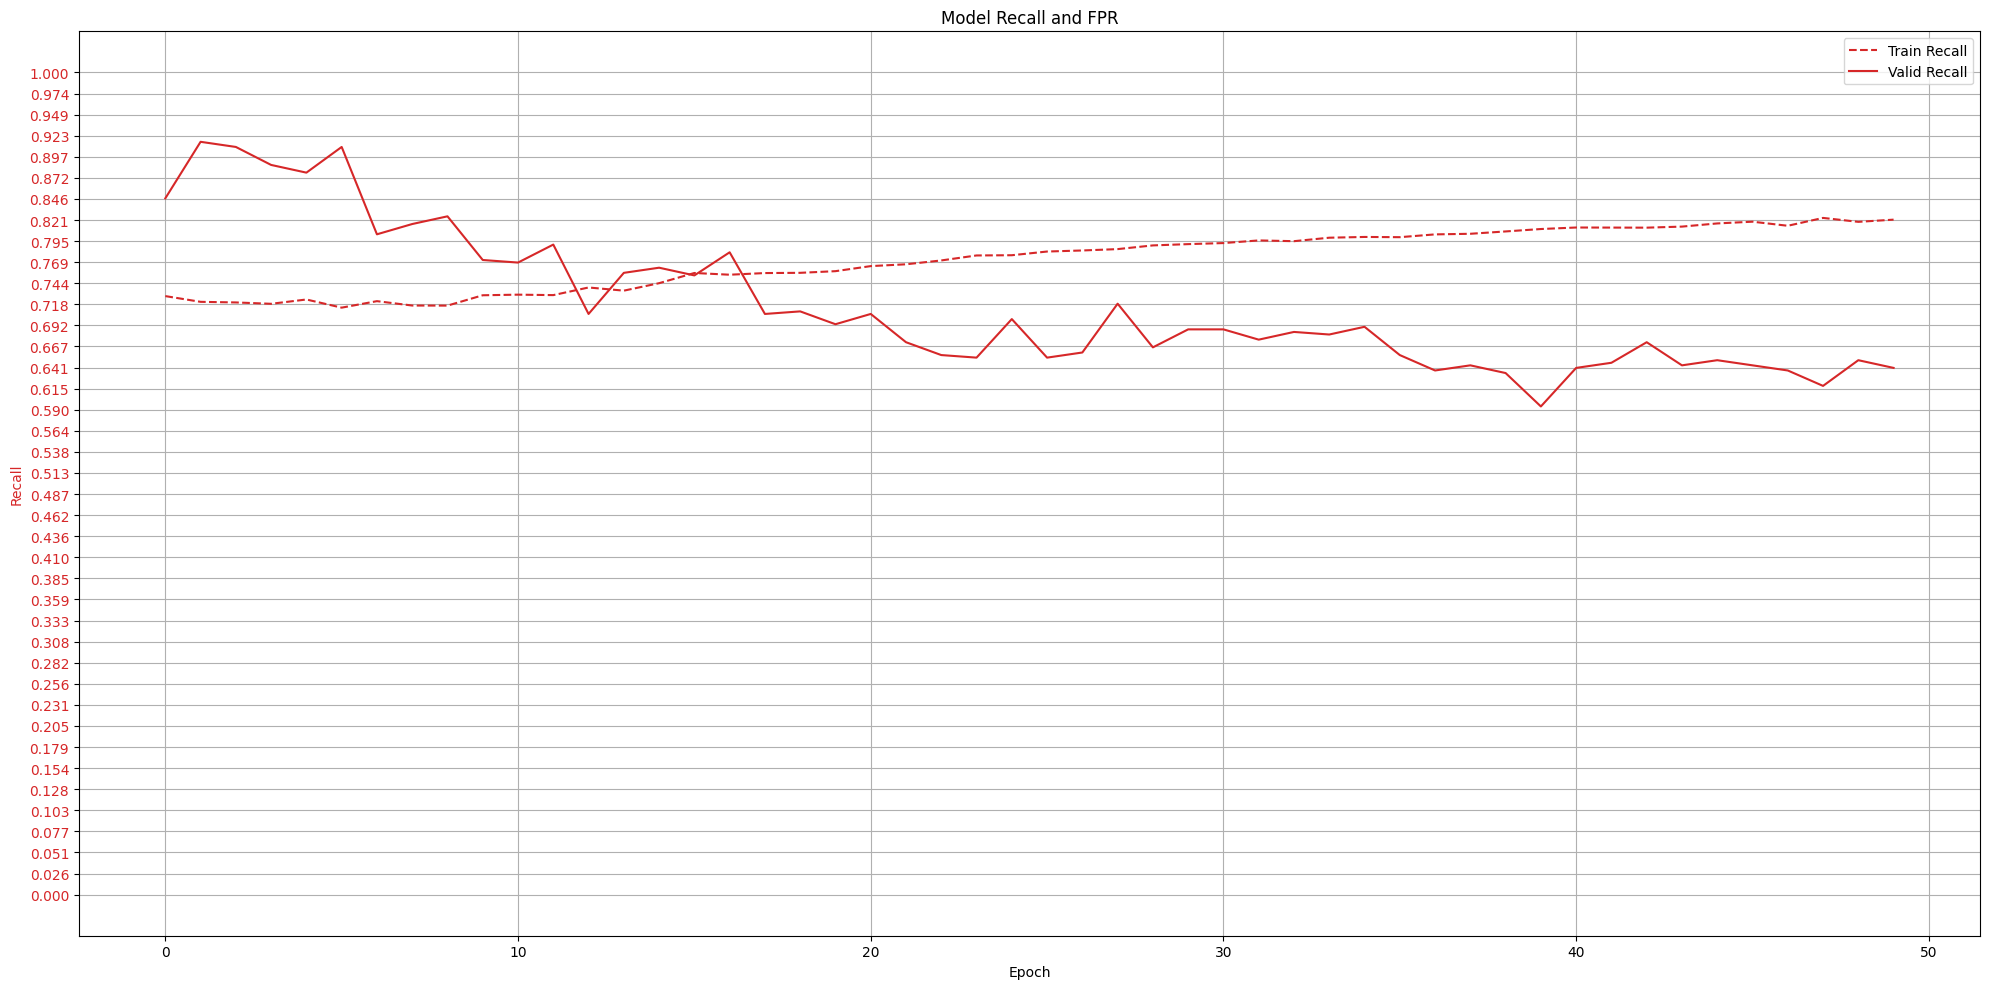

In [44]:
train_loss=[value for key, value in history.items() if 'loss' in key.lower()][0]
valid_loss=[value for key, value in history.items() if 'loss' in key.lower()][1]
train_recall=[value for key, value in history.items() if 'recall' in key.lower()][0]
valid_recall=[value for key, value in history.items() if 'recall' in key.lower()][1]

plotter = Plotter()
plotter.plot_loss(train_loss, valid_loss)
plotter.plot_model_recall_fpr(train_recall, valid_recall)

In [45]:
evaluator = Evaluator()
train, test, _ = evaluator.evaluate(mlp, x_train, y_train, x_test, y_test)

Exactitud: 0.66 / 0.69 / None
Precisión: 0.25 / 0.23 / None
Especificidad: 0.97 / 0.93 / None
Sensibilidad: 0.87 / 0.64 / None
true negative rate: 0.62 / None / 0.7
F - Score: 0.3883928571428571 / 0.33839080459770116 / None
